In [1]:
# %%
"""
Import libraries, model, and datasets
"""
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import shutil
import torch



src_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(src_dir, '..')) + '/src'  # Adjust the path as needed
print(src_dir)
sys.path.append(src_dir)

import MLC_utils as utils
import MI.model_backtrack as backtrack
import MI.model_perturbation as perturbation

src_dir = Path(src_dir)
model_path = src_dir / 'out_models' / 'net-HookedBIMLSmall.pt'
dataset_path = src_dir / 'test_data_long' 
single_trial_path = dataset_path / 'single_trial'
null_dataset_path = dataset_path / 'null_dataset.pt'


net, dataset = utils.load_net_and_dataset(model_path=model_path, 
                                              dataset_path=dataset_path, 
                                              null_dataset_path=null_dataset_path)

backtrack_analyzer = backtrack.Analyzer(dataset=dataset, net=net)
backtrack_analyzer.build_graph()

perturbation_analyzer = perturbation.Analyzer(dataset=dataset, net=net)


/Users/laptopd/Documents/Compositionality/MLC-extension/src
* Setting all random seeds to  0 *
Loading model: /Users/laptopd/Documents/Compositionality/MLC-extension/src/out_models/net-HookedBIMLSmall.pt on cpu

Transformer specs:
 nparams= 930953
 nlayers_encoder= 2
 nlayers_decoder= 2
 nhead= 8
 hidden_size= 128
 dim_feedforward= 512
 act_feedforward= gelu
 dropout= 0.1
 



/Users/laptopd/Documents/Compositionality/MLC-extension/src/MI/hooked_transformer.py:298: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/laptopd/opt/anaconda3/envs/MI/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:

# %%
"""
backtrack dec_1_5_k
"""
block = 'dec'
layer = 1
type = 'cross'
head = 5

rewrite=0

save_dir = src_dir / 'submission' / 'data' / 'dec_1_5'
save_dir.mkdir(exist_ok=True, parents=True)
backtrack_plot_dir = save_dir / 'BT_k_plot'
backtrack_data_dir = save_dir / 'BT_k_data'

if backtrack_plot_dir.exists() and rewrite:
    shutil.rmtree(backtrack_plot_dir)
    shutil.rmtree(backtrack_data_dir)

backtrack_plot_dir.mkdir(exist_ok=True, parents=True)
backtrack_data_dir.mkdir(exist_ok=True, parents=True)
output = backtrack_analyzer.output
n_batch = len(output['yq_predict'])
node = backtrack_analyzer.graph[block, layer, type, head]
attention = node.attention_score
arg_pred = np.arange(3)
arg_max_k = attention[np.arange(n_batch),0,:len(arg_pred),:].argmax(-1)

problem_stack = node.get_problems(mode='k', target_args=None)

problem_stack += node.get_problems(mode='q', target_args=None)


sort_id = 0
edges = []
while problem_stack:
    current_problem = problem_stack.pop(0)
    current_node = current_problem.current_node
    current_problem_str = f'{current_node.module_name}.{current_node.head} {current_problem.mode}'
    source_nodes = current_problem.source_stream.source_nodes


    # check if can load backtracking score from saved data
    if (backtrack_data_dir/current_problem_str).exists() and not rewrite:
        source_scores, arg_q, target_labels, target_args = torch.load(backtrack_data_dir/current_problem_str)
        print(f'Loaded {current_problem_str}')
    else:
        source_scores, arg_q, target_labels, target_args = \
        current_problem.back_track(metric='customized', eval_func=backtrack.eval_dec_cross_1_5_attn, ablate_all=True)

        torch.save([source_scores, arg_q, target_labels, target_args], backtrack_data_dir/current_problem_str)


    arg_top_nodes = backtrack.get_top_nodes(source_nodes, source_scores, n_track=1, threshold=0.5)


    # ploting the score heatmap
    if 1:
        backtrack_analyzer.plot_node_scores(target_problem = current_problem, 
            source_nodes = source_nodes, 
            source_scores = source_scores, 
            plot_dir=backtrack_plot_dir, sort_id=sort_id,
            cmap='cool', mid_0=False, include_emb=1, balance=False, display=0)
    
    # only do QKV problem
    next_nodes = [source_nodes[i] for i in arg_top_nodes]
    next_scores = [source_scores[i] for i in arg_top_nodes]
    for node, score in zip(next_nodes, next_scores):
        problems = node.get_problems(arg_q=arg_q, mode='v', prev_problem=current_problem, 
                                        target_labels=target_labels, target_args=target_args)

        # for problem in problems:
        edge_name = f'{node.module_name}{node.head}->{current_node.module_name}{current_node.head}: {current_problem.mode}'
        if edge_name in edges:
            # print(edge_name)
            continue

        problem_stack+=problems
        print(f'({sort_id}){current_problem.current_node.module_name} {current_problem.current_node.head}\
                {current_problem.mode} track back {node.module_name} {node.head}')
        edges.append(edge_name)
        sort_id+=1


* Setting all random seeds to  0 *
Loading model: /Users/laptopd/Documents/Compositionality/MLC-extension/src/out_models/net-HookedBIMLSmall.pt on cpu

Transformer specs:
 nparams= 930953
 nlayers_encoder= 2
 nlayers_decoder= 2
 nhead= 8
 hidden_size= 128
 dim_feedforward= 512
 act_feedforward= gelu
 dropout= 0.1
 



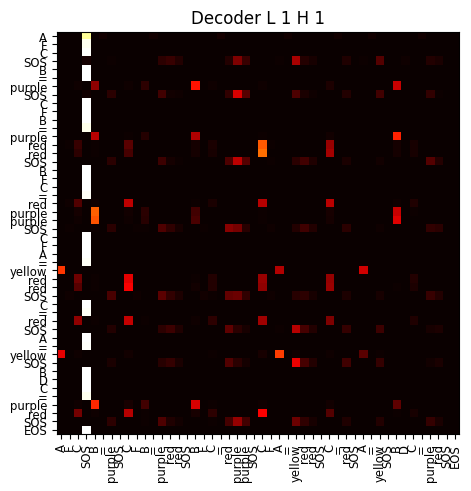

/Users/laptopd/Documents/Compositionality/MLC-extension/src/test_data/single_trial/plots/attention/enc_self_1_1.png saved


In [3]:

# %%
"""
visualize enc_1_5
"""

# %matplotlib qt
single_trial_path = src_dir / 'test_data' / 'single_trial'
plot_dir = single_trial_path / 'plots'
_, single_trial = utils.load_net_and_dataset(model_path=model_path, 
                                            dataset_path=single_trial_path, 
                                            null_dataset_path=null_dataset_path)
head_kwargs = {'block':'enc', 'layer':1, 'type':'self', 'head':1}
utils.plot_attention_patterns_by_head(dataset=single_trial, net=net, head_kwargs=head_kwargs, save_dir=plot_dir, rewrite=1, display=True)

    


/Users/laptopd/opt/anaconda3/envs/MI/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


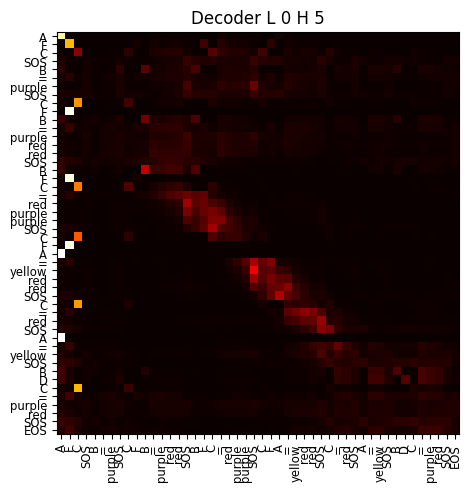

/Users/laptopd/Documents/Compositionality/MLC-extension/src/test_data/single_trial/plots/attention/enc_self_0_5.png saved


In [4]:
# %%
"""
visualize enc_0_5
"""
head_kwargs = {'block':'enc', 'layer':0, 'type':'self', 'head':5}
utils.plot_attention_patterns_by_head(dataset=single_trial, net=net, head_kwargs=head_kwargs, save_dir=plot_dir, rewrite=1, display=True)


/Users/laptopd/opt/anaconda3/envs/MI/lib/python3.10/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


receivers_chain: [[{'module': 'transformer.encoder.layers.1.self_attn.v_hook', 'head': 1}]], sender: []
receivers_chain: [[{'module': 'transformer.decoder.layers.1.multihead_attn.k_hook', 'head': 5}]], sender: []


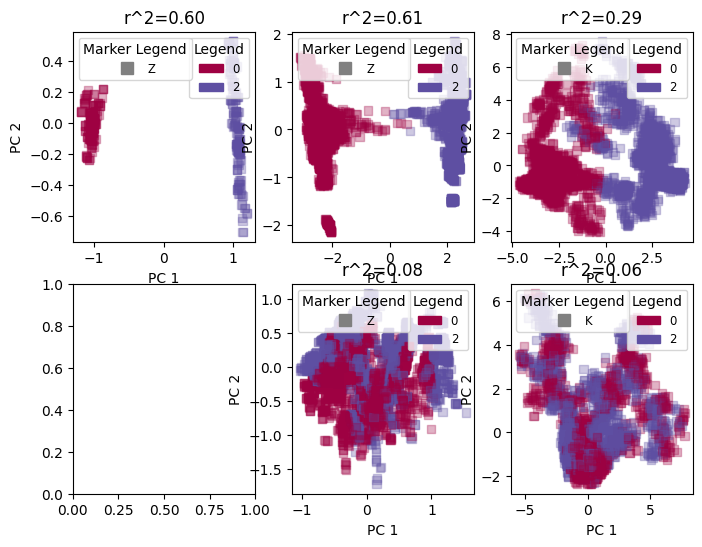

In [5]:

# %%
"""
information decoding for enc_0_5, enc_1_1, dec_1_5

"""
output_org = backtrack_analyzer.output
n_batch = len(output_org['yq'])
q_labels=[]
k_labels=[]
q_ids=[]
k_ids=[]
z_enc_0_5_clean = utils.get_activations_by_regex(net=net,
                                           cache=backtrack_analyzer.cache,
                                           hook_regex=[{'module':'*enc*0*self*z_hook*', 'head':'5'}])[0]

z_enc_1_1_clean = utils.get_activations_by_regex(net=net,
                                           cache=backtrack_analyzer.cache,
                                           hook_regex=[{'module':'*enc*1*self*z_hook*', 'head':'1'}])[0]

k_dec_1_5_clean = utils.get_activations_by_regex(net=net,
                                           cache=backtrack_analyzer.cache,
                                           hook_regex=[{'module':'*dec*1*multi*k_hook*', 'head':'5'}])[0]
# %%
"""
ablate the activation
"""
# ablate enc_1_1_v source nodes
circuit = {
    'sender_names':
        # utils.get_module_names_by_regex(net, [{'module':'*enc*0*self*z_hook*', 'head':'5'}])
        []
        ,
    'receiver_names':[
        utils.get_module_names_by_regex(net, [{'module':'*enc*1*self*v_hook*', 'head':'1'}])
        ],
    'knockout_names':                  
            utils.get_module_names_by_regex(net, [{'module':'*enc*0*self*z_hook*', 'head':'3|4|5|7'}])+
            utils.get_module_names_by_regex(net, [{'module':'*enc*0*resid_pre_hook*', 'head':'*'}])

}
patch_data = []  
cache_patch = perturbation_analyzer.run_path_patching(circuit=circuit, patch_data=patch_data)

z_enc_1_1_patch = utils.get_activations_by_regex(net=net,
                                                cache=cache_patch,
                                                hook_regex=[{'module':'*enc*1*self*z_hook*', 'head':'1'}])[0]
# ablate dec_1_5_k source nodes
circuit = {
    'sender_names':
        []
        ,
    'receiver_names':[
        utils.get_module_names_by_regex(net, [{'module':'*dec*1*multi*k_hook*', 'head':'5'}])
        ],
    'knockout_names':                  
            utils.get_module_names_by_regex(net, [{'module':'*enc*1*self*z_hook*', 'head':'0|1'}])
}
patch_data = []  
cache_patch = perturbation_analyzer.run_path_patching(circuit=circuit, patch_data=patch_data)

k_dec_1_5_patch = utils.get_activations_by_regex(net=net,
                                                cache=cache_patch,
                                                hook_regex=[{'module':'*dec*1*multi*k_hook*', 'head':'5'}])[0]
# %%
# get the q, k seq_label
arg_pred = np.arange(2)

batch_ids = []

z_enc_0_5_vectors_clean = []
z_enc_1_1_vectors_clean = []
k_dec_1_5_vectors_clean = []

z_enc_1_1_vectors_patch = []
k_dec_1_5_vectors_patch = []

z_enc_0_5_labels = []
z_enc_1_1_labels = []
k_dec_1_5_labels = []

for b in range(n_batch):
    xq_context = np.array(output_org['xq_context'][b])
    grammar_str = output_org['grammar'][b]['aux']['grammar_str']
    grammar_dict = utils.grammar_to_dict(grammar_str)
    yq = np.array(output_org['yq'][b])
    yq_predict = np.array(output_org['yq_predict'][b])
    correct = np.all(yq[arg_pred]==yq_predict[arg_pred+1])

    if (not correct) or (yq[0]==yq[1]):
        # the intact model performed 
        continue

    batch_ids.append(b)


    
    first_color = yq[0]
    first_color_poses = [i for i, token in enumerate(xq_context) if token==first_color]

    first_color_symbol = grammar_dict[1][first_color]
    first_symbol_poses = [i for i, token in enumerate(xq_context) if token==first_color_symbol]
    
    second_color = yq[1]
    second_color_poses = [i for i, token in enumerate(xq_context) if token==second_color]
    second_color_symbol = grammar_dict[1][second_color]
    second_symbol_poses = [i for i, token in enumerate(xq_context) if token==second_color_symbol]

    z_enc_0_5_vectors_clean.append(z_enc_0_5_clean[b,0,first_symbol_poses[0],:])
    z_enc_0_5_vectors_clean.append(z_enc_0_5_clean[b,0,second_symbol_poses[0],:])
    # z_enc_0_5_vectors_clean.append(z_enc_0_5_clean[b,0,first_color_poses[0],:])
    # z_enc_0_5_vectors_clean.append(z_enc_0_5_clean[b,0,second_color_poses[0],:])

    z_enc_0_5_labels.append(first_symbol_poses[0])
    z_enc_0_5_labels.append(second_symbol_poses[0])

    z_enc_1_1_vectors_clean.append(z_enc_1_1_clean[b,0,first_color_poses,:])
    z_enc_1_1_vectors_clean.append(z_enc_1_1_clean[b,0,second_color_poses,:])
    z_enc_1_1_vectors_patch.append(z_enc_1_1_patch[b,0,first_color_poses,:])
    z_enc_1_1_vectors_patch.append(z_enc_1_1_patch[b,0,second_color_poses,:])
    z_enc_1_1_labels+=[first_symbol_poses[0]]*len(first_color_poses)
    z_enc_1_1_labels+=[second_symbol_poses[0]]*len(second_color_poses)

    k_dec_1_5_vectors_clean.append(k_dec_1_5_clean[b,0,first_color_poses,:])
    k_dec_1_5_vectors_clean.append(k_dec_1_5_clean[b,0,second_color_poses,:])
    k_dec_1_5_vectors_patch.append(k_dec_1_5_patch[b,0,first_color_poses,:])
    k_dec_1_5_vectors_patch.append(k_dec_1_5_patch[b,0,second_color_poses,:])
    k_dec_1_5_labels+=[first_symbol_poses[0]]*len(first_color_poses)
    k_dec_1_5_labels+=[second_symbol_poses[0]]*len(second_color_poses)

z_enc_0_5_vectors_clean = np.vstack(z_enc_0_5_vectors_clean)
z_enc_0_5_labels = np.array(z_enc_0_5_labels)
z_enc_1_1_vectors_clean = np.vstack(z_enc_1_1_vectors_clean)
z_enc_1_1_vectors_patch = np.vstack(z_enc_1_1_vectors_patch)
k_dec_1_5_vectors_patch = np.vstack(k_dec_1_5_vectors_patch)
z_enc_1_1_labels = np.array(z_enc_1_1_labels)
k_dec_1_5_vectors_clean = np.vstack(k_dec_1_5_vectors_clean)
k_dec_1_5_labels = np.array(k_dec_1_5_labels)

fig, ax = plt.subplots(2,3,figsize=(8,6))

backtrack.plot_2D(ax=ax[0,0], source_data=[z_enc_0_5_vectors_clean], source_legends=['Z'],color_labels=[z_enc_0_5_labels],
    connect=0, markers=['s'], color_dict={1:'g'})
backtrack.plot_2D(ax=ax[0,1], source_data=[z_enc_1_1_vectors_clean], source_legends=['Z'],color_labels=[z_enc_1_1_labels],
    connect=0, markers=['s'], color_dict={1:'g'})
backtrack.plot_2D(ax=ax[0,2], source_data=[k_dec_1_5_vectors_clean], source_legends=['K'],color_labels=[k_dec_1_5_labels],
    connect=0, markers=['s'], color_dict={1:'g'})

backtrack.plot_2D(ax=ax[1,1], source_data=[z_enc_1_1_vectors_patch], source_legends=['Z'],color_labels=[z_enc_1_1_labels],
    connect=0, markers=['s'], color_dict={1:'g'})

backtrack.plot_2D(ax=ax[1,2], source_data=[k_dec_1_5_vectors_patch], source_legends=['K'],color_labels=[k_dec_1_5_labels],
    connect=0, markers=['s'], color_dict={1:'g'})
plt.show()
a=1
# %%
